
## Task 2 : Data Visualisation
**Name: Kang Hong Bo (Student ID:32684673)**
1. Streaming data visualisation<br>
   For the incoming climate data plot the line graph of air temperature against arrival time. You need to label some interesting points such as maximum and minimum values. 

In [1]:
#install folium
!pip install folium

<IPython.core.display.Javascript object>


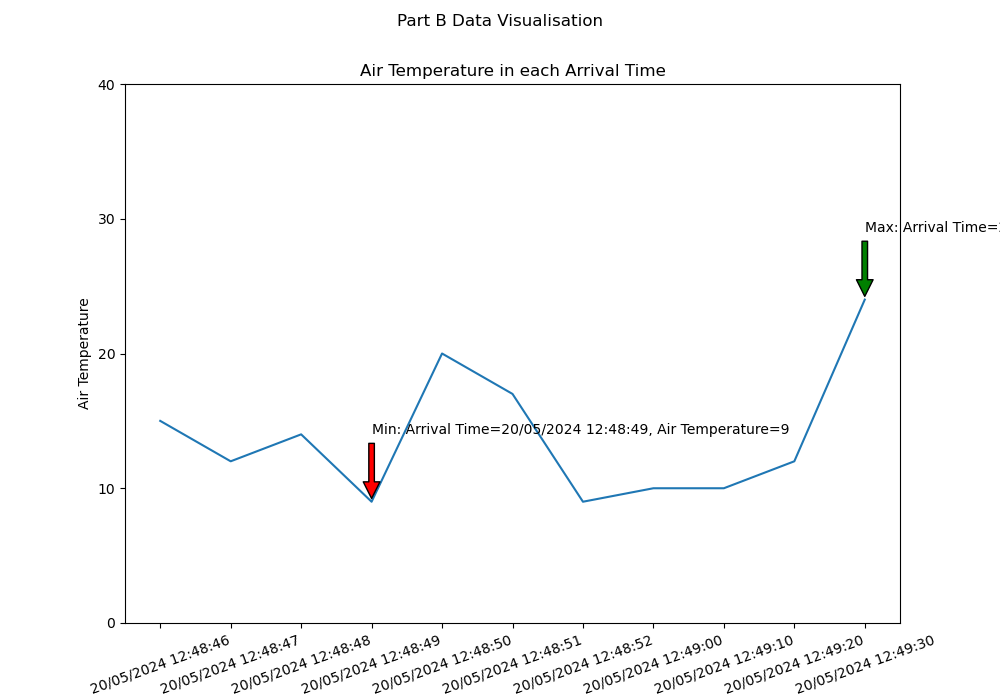

KeyboardInterrupt: 

In [2]:
import datetime as dt
import matplotlib.pyplot as plt
from kafka3 import KafkaConsumer
from time import sleep
import json


# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

ip = "192.168.22.110" ## PLEASE CHANGE THIS LINE TO YOUR HOSTIP
topic = 'PartB'

#REFERENCE FROM LAB
def annotate_max(x, y, ax=None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = f'Max: Arrival Time={xmax}, Air Temperature={ymax}'
    if not ax:
        ax = plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax + 5),
                arrowprops=dict(facecolor='green', shrink=0.05))

def annotate_min(x, y, ax=None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = f'Min: Arrival Time={xmin}, Air Temperature={ymin}'
    if not ax:
        ax = plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin + 5),
                arrowprops=dict(facecolor='red', shrink=0.05))

def connect_kafka_consumer():
    _consumer = None
    try:
        _consumer = KafkaConsumer(topic,
                                  auto_offset_reset='earliest',
                                  bootstrap_servers=[f'{ip}:9092'],
                                  value_deserializer=lambda x: json.loads(x.decode('ascii')),
                                  api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 10
        height = 7
        fig = plt.figure(figsize=(width, height))  # create new figure
        fig.subplots_adjust(hspace=0.5)
        ax1 = fig.add_subplot(111)
        ax1.set_xlabel('Arrival Time')
        ax1.set_ylabel('Air Temperature')
        fig.suptitle('Part B Data Visualisation')  # giving figure a title
        fig.show()  # displaying the figure
        fig.canvas.draw()  # drawing on the canvas
        return fig, ax1
    except Exception as ex:
        print(str(ex))

def consume_messages(consumer, fig, ax1):
    try:
        # container for x and y values
        x1, y1 = [], []
        check = 0
        firstIteration = True

        for message in consumer:
            message = message.value
#             print(message)

            if message['producer'] == 'climate_streaming':
                x1.append(dt.datetime.now().strftime('%d/%m/%Y %H:%M:%S'))  # Get the current datetime
                y1.append(message['air_temperature_celcius'])
                sleep(1)  # Sleep for one second so that we would not get overlapping date time

            # we start plotting only when we have 10 data points
            if len(y1) > 10:
                ax1.clear()
                ax1.plot(x1, y1)
                ax1.set_xlabel('Arrival Time')
                
                ax1.set_ylabel('Air Temperature')
                ax1.set_title('Air Temperature in each Arrival Time')
                ax1.set_ylim(0, 40)
                ax1.set_yticks([0, 10, 20, 30, 40])
                ax1.tick_params(axis='x', labelrotation=20)
                annotate_max(x1, y1, ax1)
                annotate_min(x1, y1, ax1)
                fig.canvas.draw()
                x1.pop(0)  # removing the item in the first position
                y1.pop(0)

        plt.close('all')
    except Exception as ex:
        print(str(ex))

if __name__ == '__main__':
    consumer = connect_kafka_consumer()
    fig, ax1 = init_plots()
    consume_messages(consumer, fig, ax1)


## 2. Static Data Visualization
(a) Plot a bar chart to visualize the total number of fire records based on each hour.

<IPython.core.display.Javascript object>


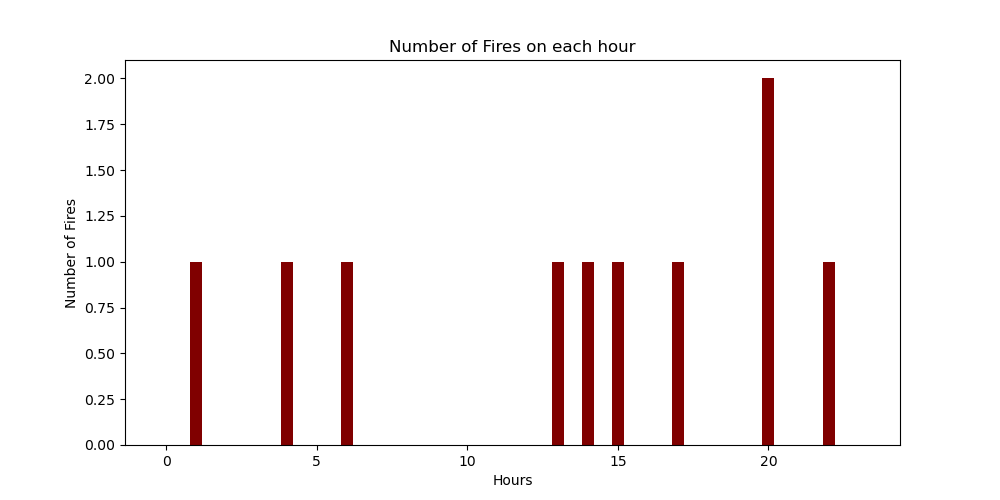

In [3]:
from pprint import pprint
from pymongo import MongoClient
ip = "192.168.22.110" ## PLEASE CHANGE THIS LINE TO YOUR HOSTIP
client = MongoClient (ip,27017) 
db = client.fit3182_assignment_db
collection = db.partB

# Unwind the hotspots data, extract the hour from the hotspot's created datetime, group the hours and get the number of fire
cursor = collection.aggregate([
    {"$unwind":"$hotspots"},
    {"$project":{"_id":0,"hour":{"$hour":"$hotspots.time"}}},
    {"$group":{"_id":"$hour","numberOfFire":{"$sum":1}}},
    {"$project":{"hour":"$_id","_id":0,"numberOfFire":1}},
    {"$sort":{"hour":1}},
    
])

# Update the number of fire for each hour, ranging from 0 to 23
hour = [i for i in range(24)]
numberOfFire = [0]*24
for document in cursor:
#     pprint(document)
    fireHour = document['hour'] # get the hour
    numberOfFire[fireHour]=document['numberOfFire'] # update the hour's number of fire
    
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(hour, numberOfFire, color ='maroon',
        width = 0.4)
plt.xlabel("Hours")
plt.ylabel("Number of Fires")
plt.title("Number of Fires on each hour")
plt.show()

(b) In a map visualise fire locations as markers. Use a ‘blue’ marker if the cause of the fire was ‘natural’. Otherwise, use a ‘red’ marker. Display detailed information such as air temperature, surface temperature, relative humidity,  and confidence with the marker tooltip. See the example below. You can use Folium for map visualisation.

In [4]:
import folium
# Preparing the data for plotting
unoccupiedList = []
marker=collection.aggregate([
    {"$unwind":"$hotspots"},
    {"$project":{
        "_id":0,
        "latitude":1,
        "longitude":1,
        "air_temperature_celcius":1,
        "fireCause":1,
        "hotspots.confidence":1,
        "relative_humidity":1,
        "hotspots.surface_temperature_celcius":1
    }}]
)

fomap = folium.Map(location=[-36.98522904875099, 144.17729838276625],zoom_start=6)
for row in marker:
    location = (float(row['latitude']), float(row['longitude']))
    popup_content = (f"airTemp={row['air_temperature_celcius']}, "
                     f"surfaceTemp={row['hotspots']['surface_temperature_celcius']}, "
                     f"relativeHumidity={row['relative_humidity']}, "
                     f"confidence={row['hotspots']['confidence']}")
    icon_color = 'blue' if row['fireCause'] == "natural" else 'red'

    # Create a Folium Marker
    folium.Marker(
        location=location,
        popup=popup_content,
        icon=folium.Icon(color=icon_color)
    ).add_to(fomap)

fomap